## Coding a Wide and Deep Model

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, Layer, Conv2D
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds

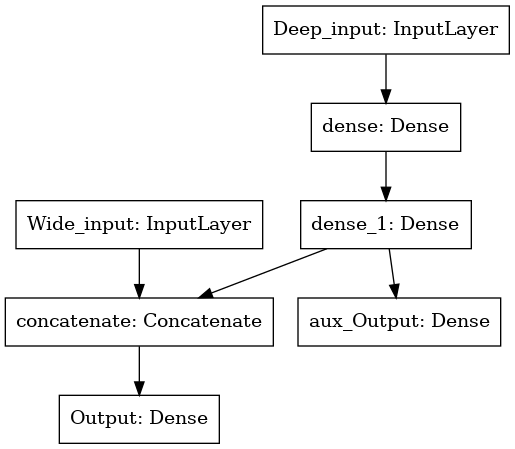

In [2]:
# Definig inputs
input_a = Input(shape=[1], name='Wide_input')
input_b = Input(shape=[1], name='Deep_input')

# Define the deep path
hidden_1 = Dense(units=30, activation='relu')(input_b)
hidden_2 = Dense(units=30, activation='relu')(hidden_1)

# Define the merge path
concat = concatenate([input_a, hidden_2])
output = Dense(1, name='Output')(concat)

# Define another output for the deep path
aux_output = Dense(1, name='aux_Output')(hidden_2)

# Build the model
model = Model(inputs=[input_a, input_b], outputs=[output, aux_output])

# Visualize the architecture
plot_model(model)

#### Implement as a Class

Inheriting from the existing Model class lets you use the Model methods such as **compile(), fit(), evaluate()**.

When inheriting from Model, you will want to define at least two functions:

 * __init__(): you will initialize the instance attributes.
 * **call()**: you will build the network and return the output layers.
 
If you compare the two methods, the structure is very similar, except when using the class, you'll define all the layers in one function, init, and connect the layers together in another function, call.

In [3]:
# Inherit from the model base class
class WideAndDeepModel(Model):
    def __init__(self, units=30, activation='relu', **kargs):
        '''Initializes the instance attributes'''
        super().__init__(**kargs)
        self.hidden_1 = Dense(units, activation=activation)
        self.hidden_2 = Dense(units, activation=activation)
        self.main_output = Dense(1)
        self.aux_output = Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden_1 = self.hidden_1(input_B)
        hidden_2 = self.hidden_2(hidden_1)
        concat = concatenate([input_A, hidden_2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden_2)
        
        return main_output, aux_output

In [5]:
model = WideAndDeepModel()

### Residual Networks

In [11]:
class CNNResidual(Layer):
    def __init__(self, layers, filters, **kargs):
        super().__init__(**kargs)
        self.hidden = [Conv2D(filters, (3, 3), activations='relu') for _ in range(layers)]
        
    def call(slef, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        return inputs + x

In [12]:
class DNNResidual(Layer):
    def __init__(self, layers, neurons, **kargs):
        super().__init__(**kargs)
        self.hidden = [Dense(units=neurons, activation='relu') for _ in range(layers)]
        
    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        return inputs + x

In [13]:
class Residual(Model):
    def __init__(self, **kargs):
        super().__init__(**kargs)
        self.hidden = Dense(30, activation='relu')
        self.block1 = CNNResidual(2, 32)
        self.block2 = DNNResidual(2, 64)
        self.out = Dense(1)
        
    def call(self, inputs):
        x = self.hidden(inputs)
        x = self.block1(x)
        
        for _ in range(1, 3):
            x = self.block2(x)
            
        return self.out(x)

### ResNet

In [22]:
class IdentityBlock(Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock, self).__init__(name='')
        self.conv1 = Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
        
    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)
        
        x = self.add([x, input_tensor])
        x = self.act(x)
        
        return x

In [25]:
class ResNet(Model):
    def __init__(self, num_class):
        super(ResNet, self).__init__()
        self.conv = Conv2D(64, 7, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))
        
        self.ida = IdentityBlock(64, 3)
        self.idb = IdentityBlock(64, 3)
        
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = Dense(num_class, activation='softmax')
        
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)
        
        x = self.ida(x)
        x = self.idb(x)
        
        x = self.global_pool(x)
        
        return self.classifier(x)
        

In [31]:
def preprocess(features):
    return tf.cast(features['image'], tf.float32) / 255.0, features['label']

In [32]:
resnet = ResNet(10)
resnet.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

dataset = tfds.load('mnist', split=tfds.Split.TRAIN)
dataset = dataset.map(preprocess).batch(32)

resnet.fit(dataset, epochs=1)

1875/1875 [==============================] - 171s 91ms/step - loss: 0.3235 - accuracy: 0.9204
